In [4]:
# line plot seprated by group and gene body and promotor 

# ============================================================
# NHIP: 4 line plots (smoothed methylation), 10 categories
#   Promoter(Control), Promoter(Condition),
#   GeneBody(Control), GeneBody(Condition)
#   Each line = tissue/region category
# ============================================================

import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.ndimage import gaussian_filter1d
import matplotlib.cm as cm
from matplotlib.patches import Patch

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['figure.dpi'] = 300
matplotlib.rcParams['savefig.transparent'] = True
matplotlib.rcParams['path.simplify'] = False  # keep exact vectors

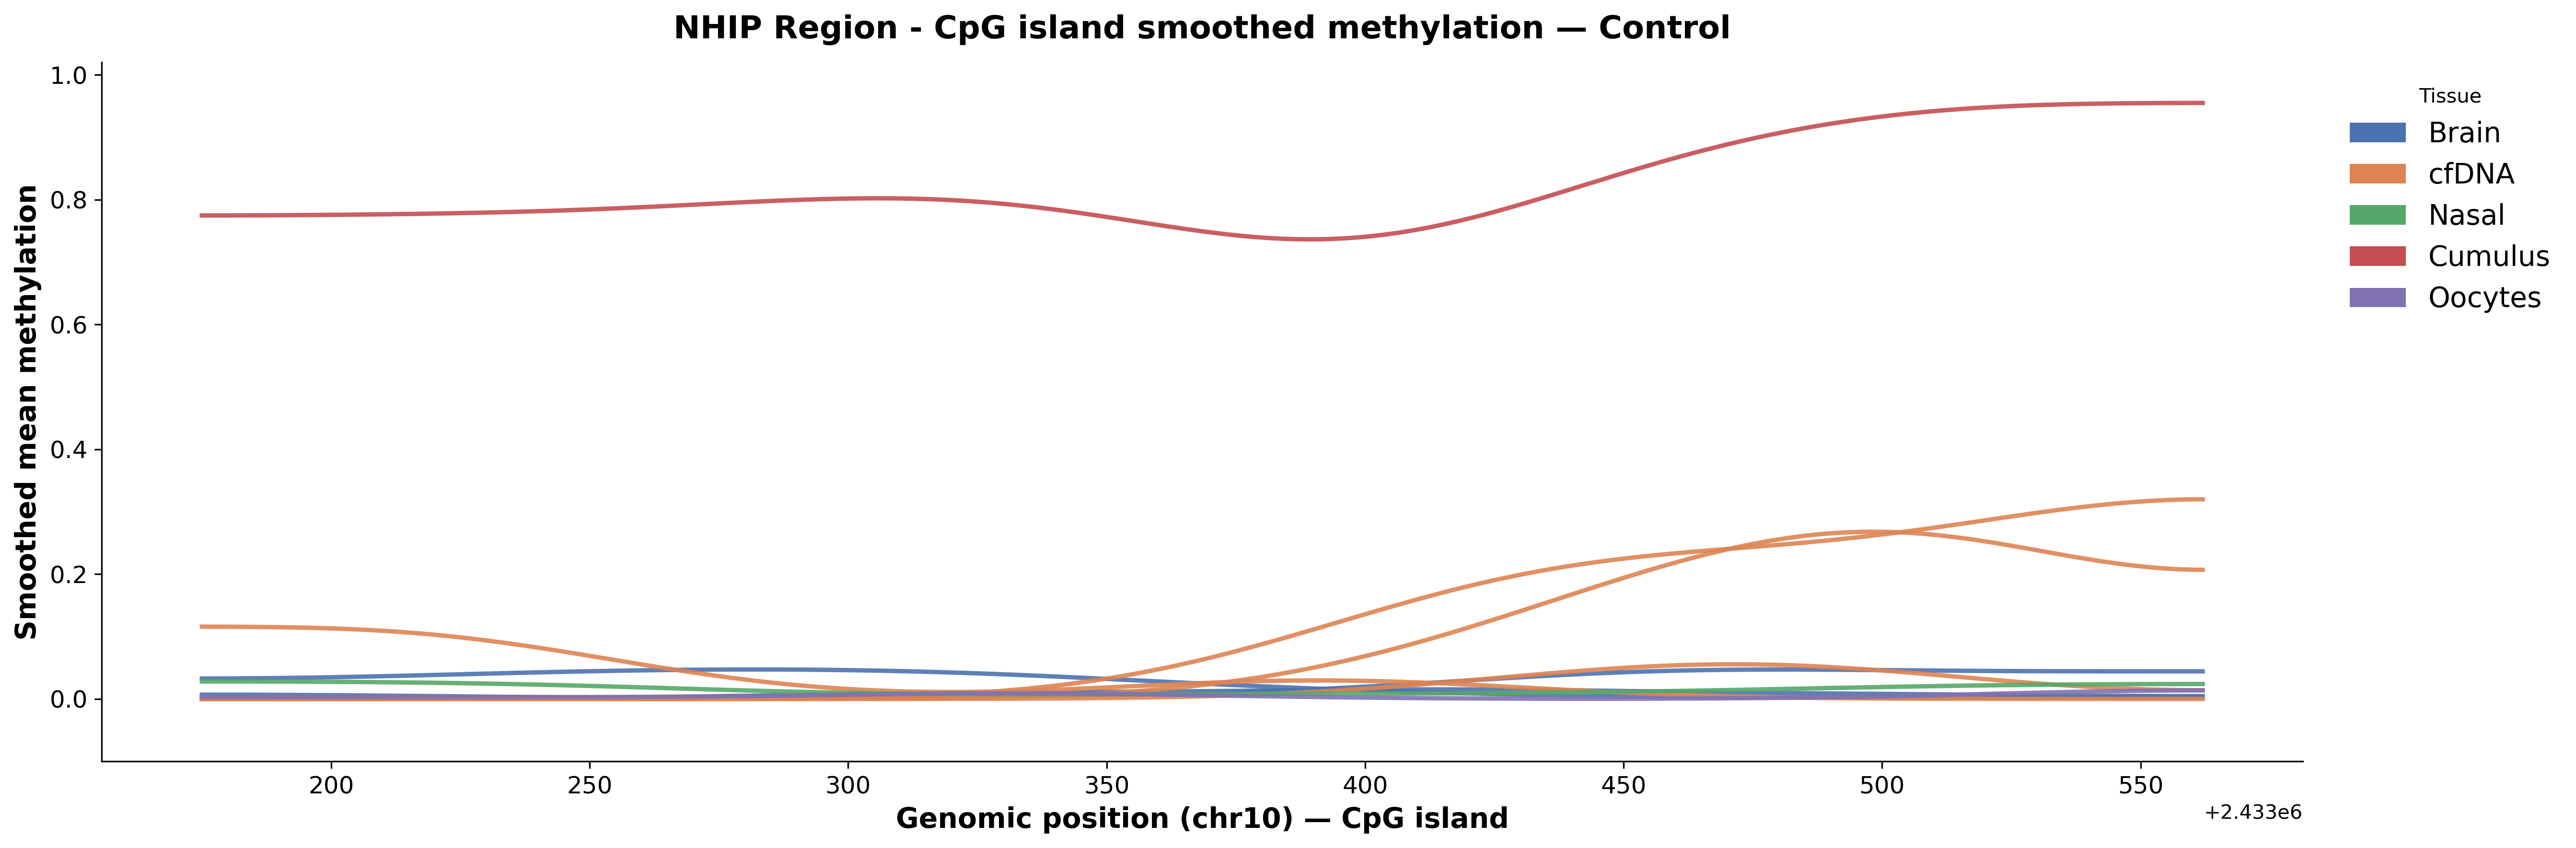

Saved: NHIP_10categories_lines_promoter_Control.pdf


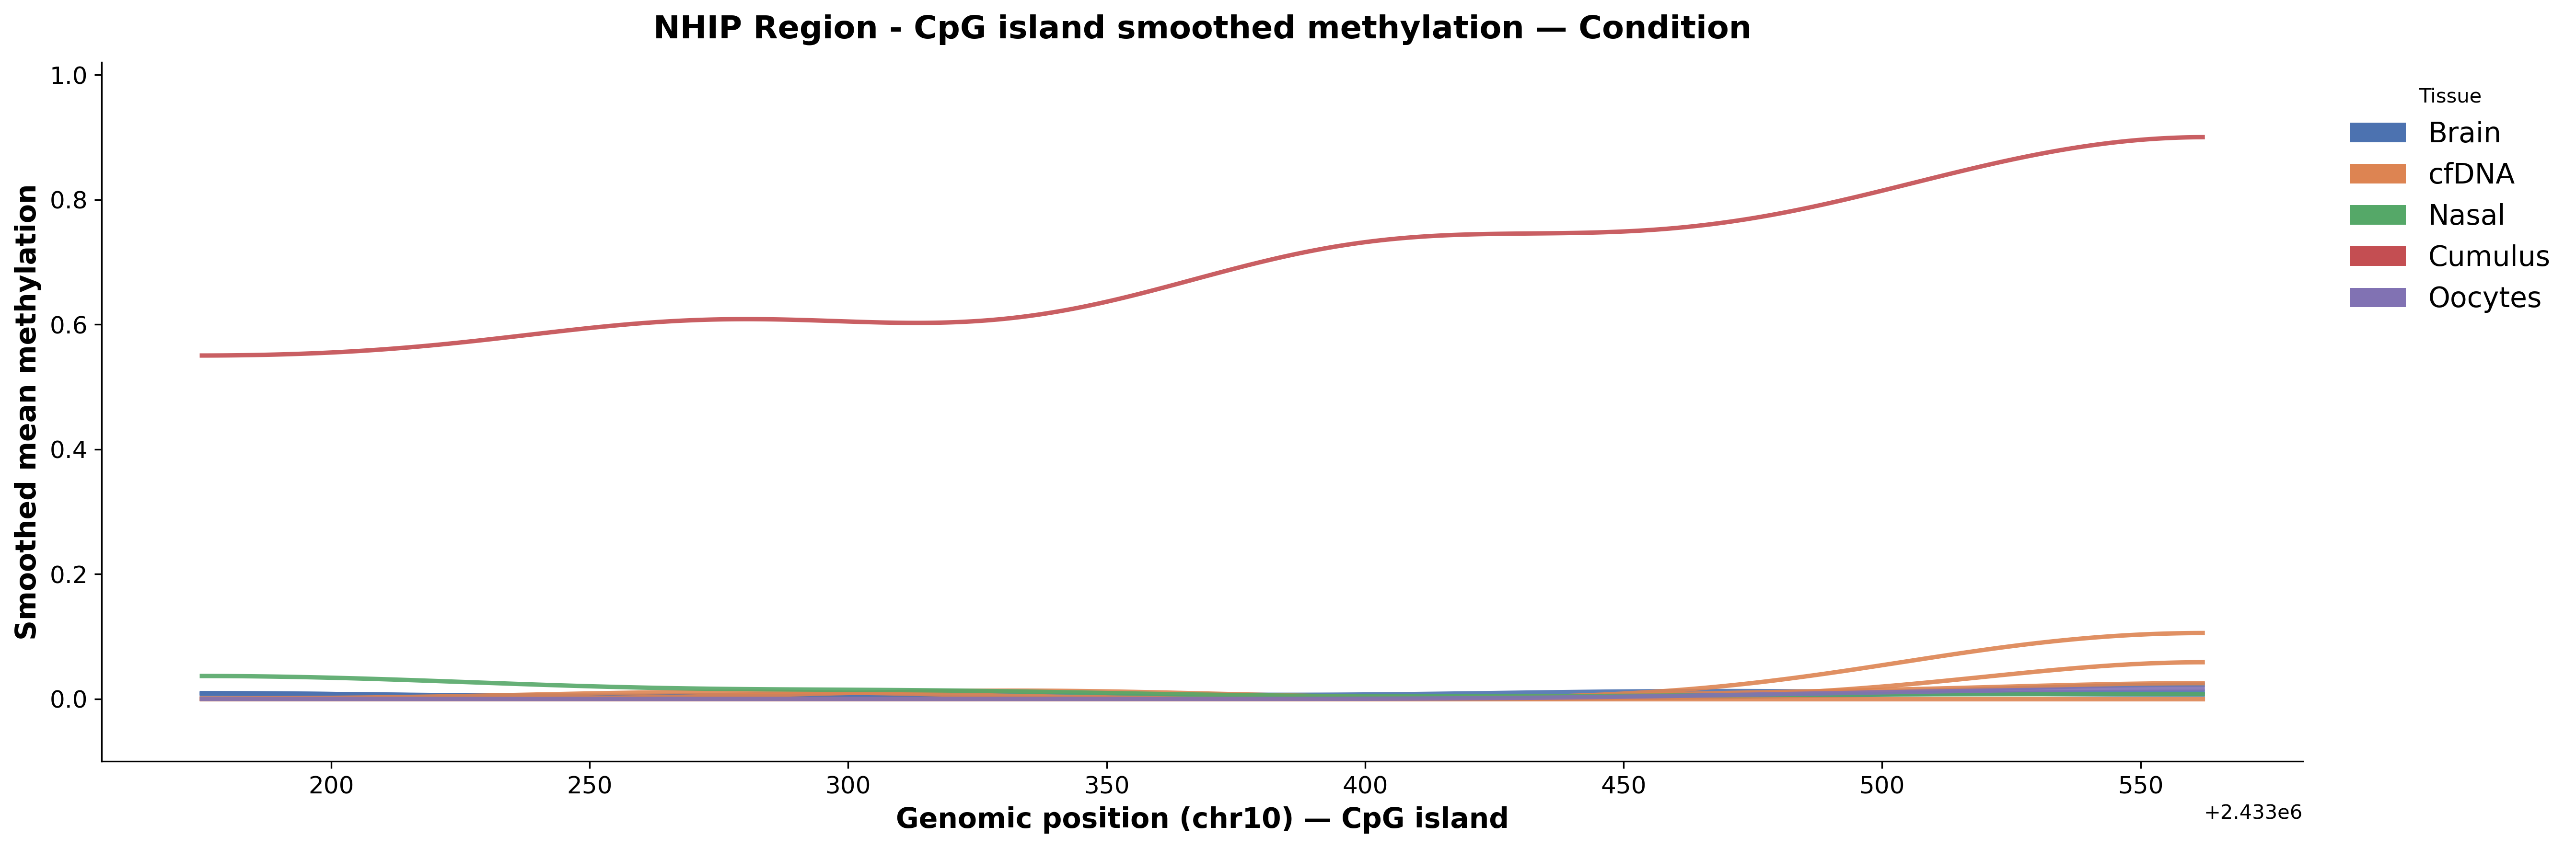

Saved: NHIP_10categories_lines_promoter_Condition.pdf


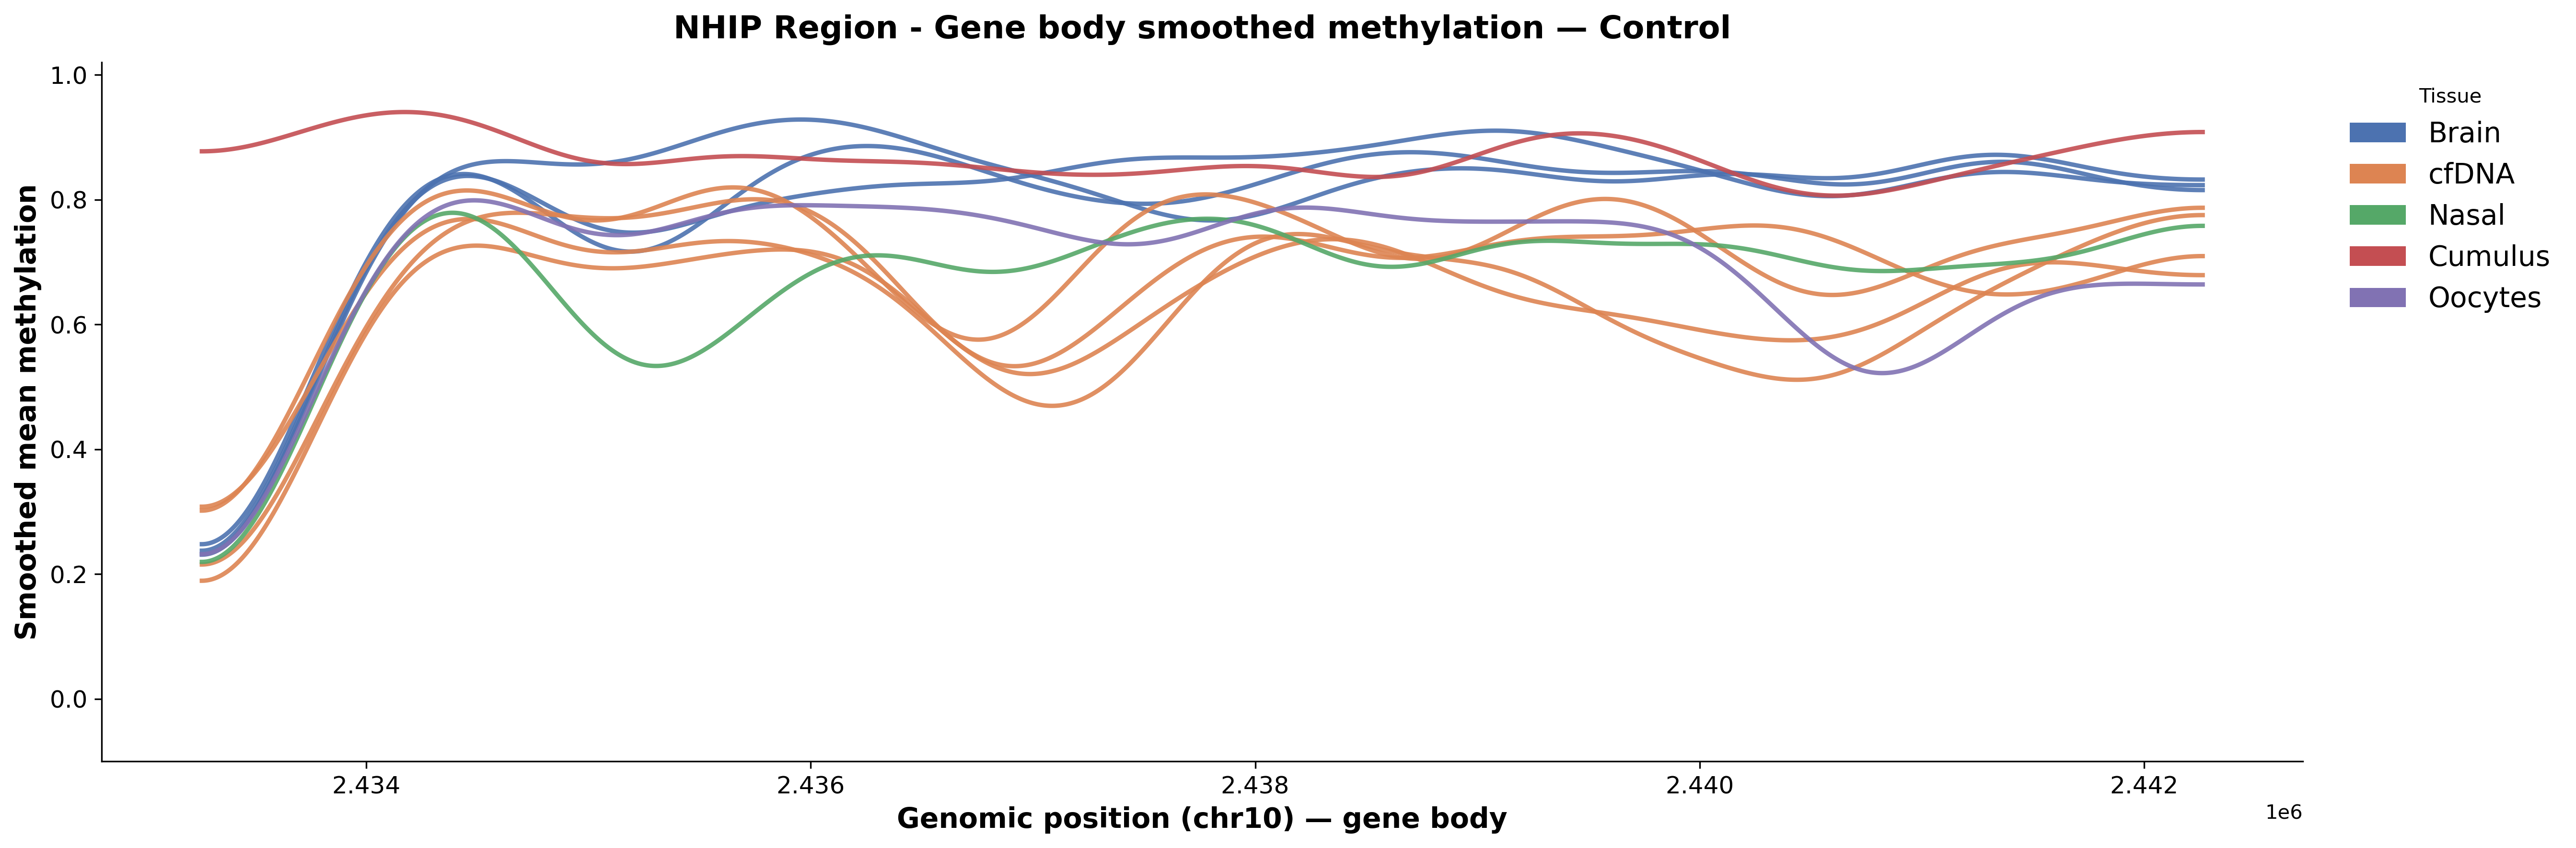

Saved: NHIP_10categories_lines_genebody_Control.pdf


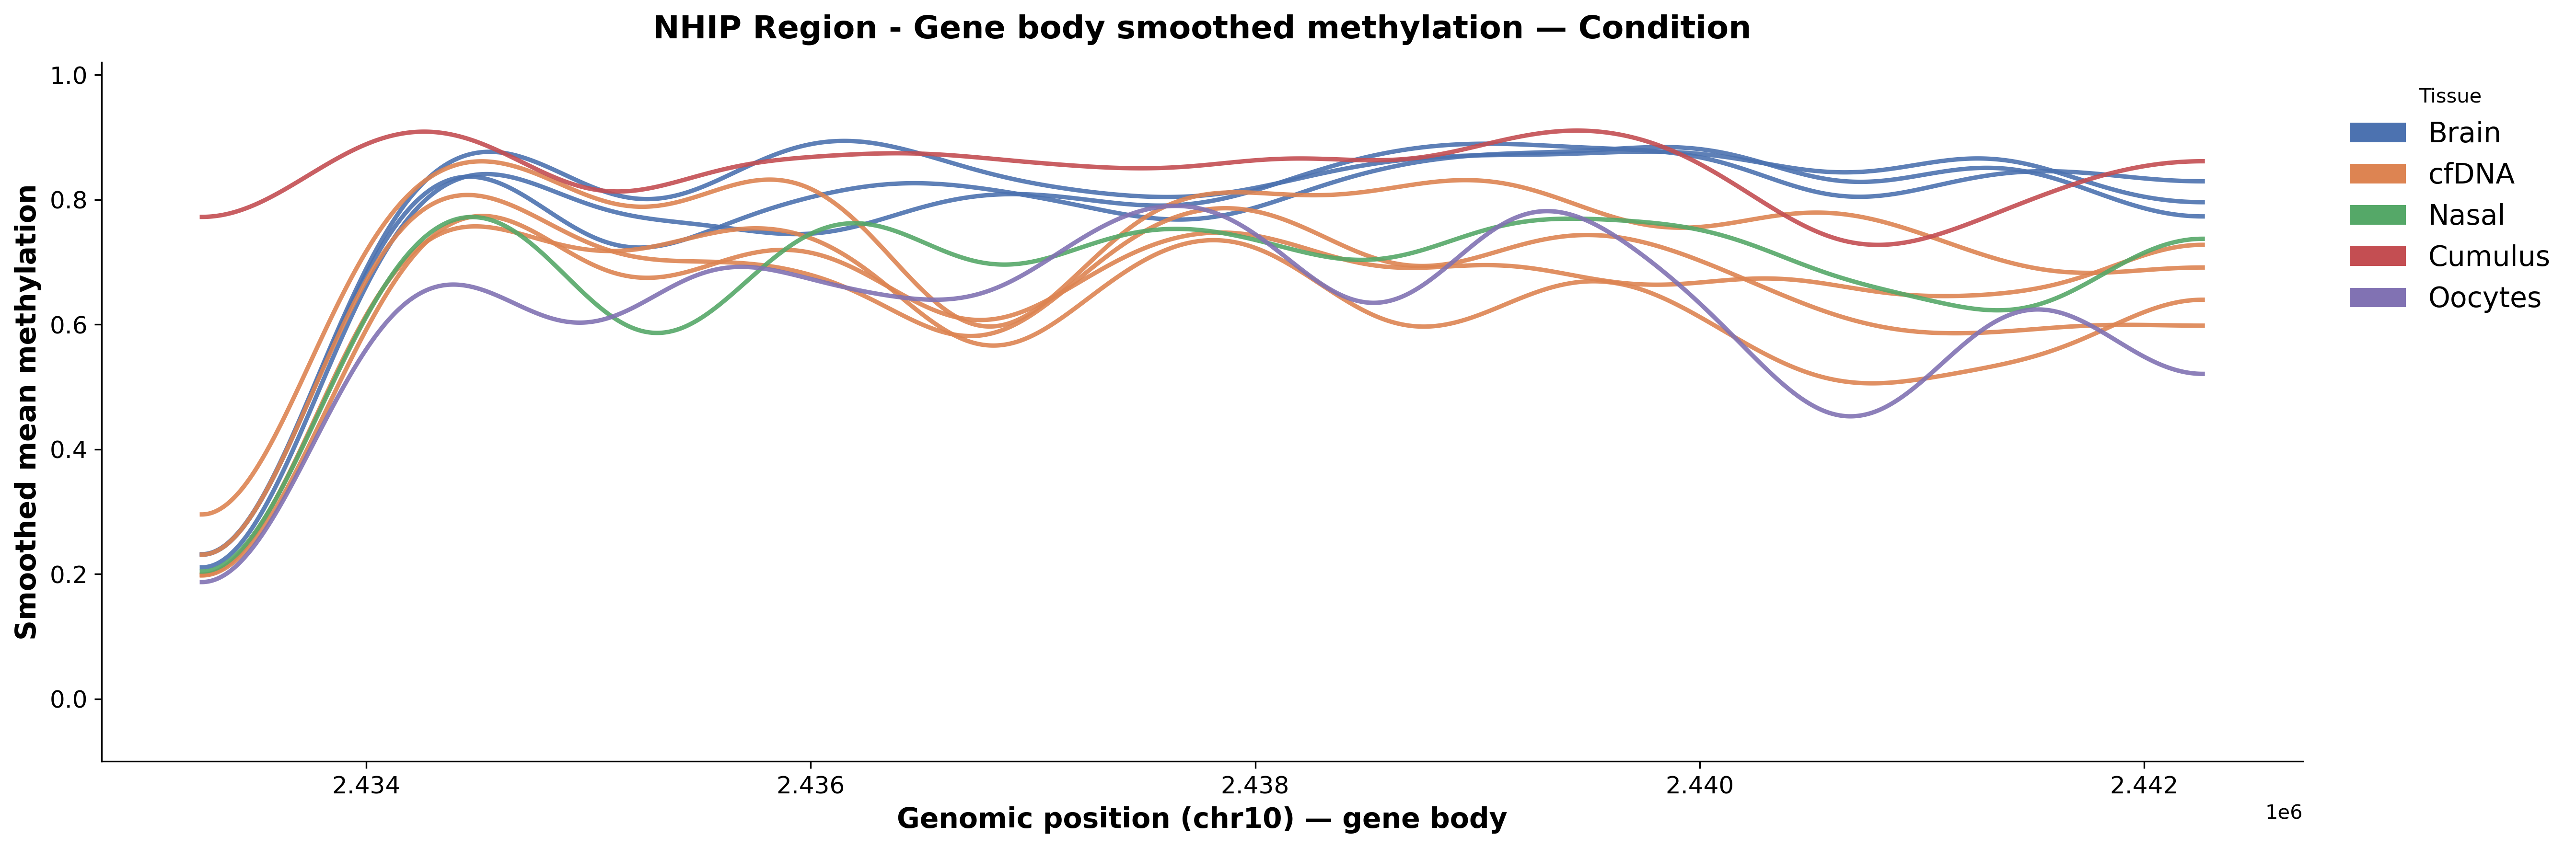

Saved: NHIP_10categories_lines_genebody_Condition.pdf


In [9]:



# distinct colors for each tissue/region
# ---------------------------------------------
# Colors by tissue type (not region/GD)
# ---------------------------------------------
TISSUE_COLORS = {
    "brain":   "#4C72B0",  # blue
    "cfDNA":   "#DD8452",  # orange
    "nasal":   "#55A868",  # green
    "cumulus": "#C44E52",  # red
    "oocytes": "#8172B3",  # purple
}


# -------------------- Common region definitions --------------------
chrom = "chr10"
region_start = 2432261
region_end   = 2443263

# Promoter window (CpG island)
cpg_start = 2433175
cpg_end   = 2433562

# Gene body window
gene_body_start = region_start + 1000
gene_body_end   = region_end - 1000

# Smoothing: adjust if you want more/less smooth
SMOOTH_SIGMA_PROMOTER = 40   # narrower, preserves local structure
SMOOTH_SIGMA_GENEBODY = 400  # wider, smoother long-range trend


# 10 categories in desired order
X_LEVELS = [
    "brain:Hypothalamus",
    "brain:Hippocampus",
    "brain:PrefrontalCortex",
    "cfDNA:GD45",
    "cfDNA:GD90",
    "cfDNA:GD120",
    "cfDNA:GD150",
    "nasal:ROI",
    "cumulus:ROI",
    "oocytes:ROI",
]

X_LABELS_PRETTY = [
    "Brain: Hypothalamus",
    "Brain: Hippocampus",
    "Brain: PrefrontalCortex",
    "cfDNA: GD45",
    "cfDNA: GD90",
    "cfDNA: GD120",
    "cfDNA: GD150",
    "Nasal: ROI",
    "Cumulus: ROI",
    "Oocytes: ROI",
]

# Group colors (as requested)
GROUP_COLORS = {
    "Control": "#4C72B0",
    "Condition": "#DD8452",
}

# -------------------- Helpers --------------------
def roi_frac_series_from_covlike_tsv_gz(path: str, chrom: str) -> pd.Series:
    """
    For cov/roi-like files with columns:
      chrom start end pct meth unmeth
    Returns series indexed by start position with fraction meth.
    """
    cols = ["chrom", "start", "end", "pct", "meth", "unmeth"]
    df = pd.read_csv(path, sep="\t", header=None, names=cols, compression="gzip")
    if df.empty:
        return pd.Series(dtype=float)

    df = df[df["chrom"] == chrom].copy()
    if df.empty:
        return pd.Series(dtype=float)

    denom = (df["meth"] + df["unmeth"]).replace(0, np.nan)
    df["frac"] = df["meth"] / denom
    df = df.dropna(subset=["frac"])

    return pd.Series(df["frac"].values, index=df["start"].astype(int).values)


def allcools_pos_meth_series_from_tsv(path: str) -> pd.Series:
    """
    For allcools-style region TSV:
      pos type meth
    Returns series indexed by pos with meth in [0,1].
    """
    df = pd.read_csv(path, delim_whitespace=True, header=None, names=["pos", "type", "meth"]).dropna()
    if df.empty:
        return pd.Series(dtype=float)
    df = df.astype({"pos": int, "meth": float})
    return pd.Series(df["meth"].values, index=df["pos"].values)


def window_grid_and_smooth(series_list, start, end, sigma=60):
    """
    Given list of per-sample Series (index=pos, value=meth),
    produce mean-over-samples on a base grid [start..end],
    interpolate missing, then Gaussian smooth.
    Returns (grid_positions, smoothed_mean)
    """
    grid = np.arange(start, end + 1)

    # accumulate values per position across samples
    pos_to_vals = {}
    for s in series_list:
        if s is None or len(s) == 0:
            continue
        # restrict early for speed
        s2 = s[(s.index >= start) & (s.index <= end)]
        for p, v in s2.items():
            pos_to_vals.setdefault(int(p), []).append(float(v))

    if len(pos_to_vals) == 0:
        return grid, np.full_like(grid, np.nan, dtype=float)

    mean_vals = []
    for p in grid:
        vals = pos_to_vals.get(int(p), [])
        mean_vals.append(np.mean(vals) if len(vals) else np.nan)

    mean_vals = pd.Series(mean_vals, index=grid).interpolate(limit_direction="both").values
    smoothed = gaussian_filter1d(mean_vals, sigma=sigma)
    return grid, smoothed


# -------------------- Load per-sample series for each category & group --------------------
def collect_brain_series(region_name: str):
    PROJECT = Path("/quobyte/lasallegrp/Ensi/project/nhip_macaque/fromBen_MacaqueObese_brain/")
    DMRS_DIR = PROJECT / "DMRs"
    METADATA = DMRS_DIR / "sample_info_master.csv"  # tab-separated

    meta = pd.read_csv(METADATA, sep="\t")
    meta["Name"] = meta["Name"].astype(str)
    cond = meta["Obese"].astype(str)
    meta["grp2"] = np.where(cond.str.lower() == "obese", "Condition", "Control")
    name_to_grp2 = dict(zip(meta["Name"], meta["grp2"]))

    dmr_dir = DMRS_DIR / f"{region_name}_OvC"
    roi_files = sorted(glob.glob(str(dmr_dir / "*.roi.tsv.gz")))
    cov_files = sorted(glob.glob(str(dmr_dir / "*.cov.gz")))
    files_to_use = roi_files if roi_files else cov_files

    out = {"Control": [], "Condition": []}
    for fpath in files_to_use:
        base = os.path.basename(fpath)
        sample = base.split("_", 1)[0]
        if sample not in name_to_grp2:
            continue
        grp2 = name_to_grp2[sample]
        if grp2 not in out:
            continue
        s = roi_frac_series_from_covlike_tsv_gz(fpath, chrom=chrom)
        if len(s):
            out[grp2].append(s)
    return out


def collect_cfdna_series(gd_label: str):
    PROJECT = Path("/quobyte/lasallegrp/Ensi/project/nhip_macaque/fromBen_MacaqueObese_cfDna/")
    DMRS_DIR = PROJECT / "DMRs"
    METADATA = DMRS_DIR / "master_sample_info_cfDNA.csv"

    meta = pd.read_csv(METADATA)
    meta["Name"] = meta["Name"].astype(str)
    meta["Group"] = meta["Group"].astype(str)
    name_to_group = dict(zip(meta["Name"], meta["Group"]))

    dmr_dir = DMRS_DIR / f"{gd_label}_OvC"
    roi_files = sorted(glob.glob(str(dmr_dir / "*.roi.tsv.gz")))

    out = {"Control": [], "Condition": []}
    for fpath in roi_files:
        sample = os.path.basename(fpath).replace(".roi.tsv.gz", "")
        if sample not in name_to_group:
            continue
        graw = str(name_to_group[sample]).lower()
        grp2 = "Condition" if "obese" in graw else "Control"
        s = roi_frac_series_from_covlike_tsv_gz(fpath, chrom=chrom)
        if len(s):
            out[grp2].append(s)
    return out


def collect_nasal_series():
    PROJECT = Path("/quobyte/lasallegrp/Ensi/project/nhip_macaque/macaque_nasal_HongJi/")
    OUT_DIR  = PROJECT / "roi_tsvfiles"
    METADATA = PROJECT / "sample_info_master.csv"

    meta = pd.read_csv(METADATA, sep=",")
    meta["Name"] = meta["Name"].astype(str)
    meta["Group"] = meta["Group"].astype(str)
    name_to_group = dict(zip(meta["Name"], meta["Group"]))

    out = {"Control": [], "Condition": []}
    for fpath in sorted(glob.glob(str(OUT_DIR / "*.tsv.gz"))):
        base = os.path.basename(fpath)
        sample = base.split("_", 1)[0]
        if sample not in name_to_group:
            continue
        g = name_to_group[sample]
        if g not in {"Control", "Exposed"}:
            continue
        grp2 = "Control" if g == "Control" else "Condition"
        s = roi_frac_series_from_covlike_tsv_gz(fpath, chrom=chrom)
        if len(s):
            out[grp2].append(s)
    return out


def collect_cumulus_series():
    ROOT = Path("/quobyte/lasallegrp/Ensi/project/nhip_macaque/nhip_cumulus/")
    META = ROOT / "sample_info.csv"
    DATA_DIR = ROOT / "methyl_region_data"

    meta = pd.read_csv(META, sep="\t")
    meta["Name"] = meta["Name"].astype(str)
    meta["Group"] = meta["Group"].astype(str)
    sample_to_group = dict(zip(meta["Name"], meta["Group"]))

    out = {"Control": [], "Condition": []}
    for fpath in sorted(glob.glob(str(DATA_DIR / "*_merged_name_sorted.deduplicated.sorted.chr.tsv"))):
        sample = os.path.basename(fpath).replace("_merged_name_sorted.deduplicated.sorted.chr.tsv", "")
        if sample not in sample_to_group:
            continue
        g = str(sample_to_group[sample]).lower()
        # map to Control vs Condition (stress)
        grp2 = "Control" if g.startswith("c") or "control" in g else "Condition"
        s = allcools_pos_meth_series_from_tsv(fpath)
        if len(s):
            out[grp2].append(s)
    return out


def collect_oocytes_series() -> pd.DataFrame:
    ROOT = Path("/quobyte/lasallegrp/Ensi/project/nhip_macaque/nhip_oocytes/")
    DATA_DIR = ROOT / "roi_tsvfiles"
    
    out: dict[str, list[pd.Series]] = {"Control": [], "Condition": []}

    rows = []
    for fpath in sorted(glob.glob(str(DATA_DIR / "*.CpGreport.txt.gz.CpGreport.mergedCpGevidence.roi1kb.tsv.gz"))):
        fname = os.path.basename(fpath)
        sample = fname.replace(".CpGreport.txt.gz.CpGreport.mergedCpGevidence.roi1kb.tsv.gz", "")

        # infer group from filename
        if sample.endswith("C"):
            grp2 = "Control"
        elif sample.endswith("S"):
            grp2 = "Condition"
        else:
            continue

        s = roi_frac_series_from_covlike_tsv_gz(fpath, chrom=chrom)
        if not s.empty:
            out[grp2].append(s)

    return out

# ----helper function


def tissue_from_category(cat: str) -> str:
    if cat.startswith("brain:"):
        return "brain"
    if cat.startswith("cfDNA:"):
        return "cfDNA"
    if cat.startswith("nasal:"):
        return "nasal"
    if cat.startswith("cumulus:"):
        return "cumulus"
    if cat.startswith("oocytes:"):
        return "oocytes"
    raise ValueError(f"Unknown category: {cat}")

    
# -------------------- Build smoothed line for each category x group x window --------------------
def build_category_lines():
    """
    Returns dict:
      lines[(window_name, grp2)][category_label] = (x_grid, y_smoothed)
    where window_name in {"promoter","genebody"} and grp2 in {"Control","Condition"}.
    """
    # Collect per-sample series for each category
    cat_to_series = {}

    # brain
    for region in ["Hypothalamus", "Hippocampus", "PrefrontalCortex"]:
        cat = f"brain:{region}"
        cat_to_series[cat] = collect_brain_series(region)

    # cfDNA
    for gd in ["GD45", "GD90", "GD120", "GD150"]:
        cat = f"cfDNA:{gd}"
        cat_to_series[cat] = collect_cfdna_series(gd)

    # single ROI tissues
    cat_to_series["nasal:ROI"] = collect_nasal_series()
    cat_to_series["cumulus:ROI"] = collect_cumulus_series()
    cat_to_series["oocytes:ROI"] = collect_oocytes_series()

    # Make smoothed lines
    lines = {
        ("promoter", "Control"): {},
        ("promoter", "Condition"): {},
        ("genebody", "Control"): {},
        ("genebody", "Condition"): {},
    }

    # promoter window grid
    p_start, p_end = cpg_start, cpg_end
    g_start, g_end = gene_body_start, gene_body_end

    for cat in X_LEVELS:
        if cat not in cat_to_series:
            continue
        for grp2 in ["Control", "Condition"]:
            series_list = cat_to_series[cat].get(grp2, [])

            xP, yP = window_grid_and_smooth(
                series_list, p_start, p_end,
                sigma=SMOOTH_SIGMA_PROMOTER
            )

            xG, yG = window_grid_and_smooth(
                series_list, g_start, g_end,
                sigma=SMOOTH_SIGMA_GENEBODY
            )


            lines[("promoter", grp2)][cat] = (xP, yP)
            lines[("genebody", grp2)][cat] = (xG, yG)

    return lines


# -------------------- Plotting --------------------
def plot_lines(lines, window_name, grp2, out_prefix):
    """
    window_name: "promoter" or "genebody"
    grp2: "Control" or "Condition"
    """
    fig, ax = plt.subplots(figsize=(18, 6))


    # plot in the same order as X_LEVELS
    for cat, pretty in zip(X_LEVELS, X_LABELS_PRETTY):
        x, y = lines[(window_name, grp2)].get(cat, (None, None))
        if x is None or y is None or np.all(np.isnan(y)):
            continue

        tissue = tissue_from_category(cat)
        ax.plot(
            x,
            y,
            linewidth=2.2,
            color=TISSUE_COLORS[tissue],
            alpha=0.9,
            label=pretty
        )



    ax.set_ylim(-0.1, 1.02)
    ax.set_ylabel("Smoothed mean methylation", fontsize=14, fontweight="bold")

    if window_name == "promoter":
        ax.set_xlabel(f"Genomic position ({chrom}) — CpG island", fontsize=14, fontweight="bold")
        ttl = f"NHIP Region - CpG island smoothed methylation — {grp2}"
    else:
        ax.set_xlabel(f"Genomic position ({chrom}) — gene body", fontsize=14, fontweight="bold")
        ttl = f"NHIP Region - Gene body smoothed methylation — {grp2}"

    ax.set_title(ttl, fontsize=16, fontweight="bold", pad=12)
    ax.tick_params(axis="both", labelsize=12)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Legend outside

    legend_elements = [
        Patch(facecolor=TISSUE_COLORS["brain"],   label="Brain"),
        Patch(facecolor=TISSUE_COLORS["cfDNA"],   label="cfDNA"),
        Patch(facecolor=TISSUE_COLORS["nasal"],   label="Nasal"),
        Patch(facecolor=TISSUE_COLORS["cumulus"], label="Cumulus"),
        Patch(facecolor=TISSUE_COLORS["oocytes"], label="Oocytes"),
    ]

    ax.legend(
        handles=legend_elements,
        loc="upper left",
        bbox_to_anchor=(1.01, 1),
        frameon=False,
        fontsize=14,
        title="Tissue"
    )


    plt.tight_layout()
    #out_png = f"{out_prefix}_{window_name}_{grp2}.png"
    out_pdf = f"{out_prefix}_{window_name}_{grp2}.pdf"
    #plt.savefig(out_png, dpi=300)
    plt.savefig(out_pdf)
    plt.show()
    #print("Saved:", out_png)
    print("Saved:", out_pdf)


def main():
    lines = build_category_lines()

    # 4 plots as requested
    plot_lines(lines, "promoter", "Control",   out_prefix="NHIP_10categories_lines")
    plot_lines(lines, "promoter", "Condition", out_prefix="NHIP_10categories_lines")
    plot_lines(lines, "genebody", "Control",   out_prefix="NHIP_10categories_lines")
    plot_lines(lines, "genebody", "Condition", out_prefix="NHIP_10categories_lines")


if __name__ == "__main__":
    main()


In [10]:
pd = collect_oocytes_series()
pd


{'Control': [2432339    1.0
  2432384    1.0
  2432400    1.0
  2434565    1.0
  2434607    0.0
  2434611    0.0
  2434650    0.0
  2434889    1.0
  2435587    1.0
  2435598    1.0
  2435627    1.0
  2435631    1.0
  2435633    1.0
  2435639    1.0
  2435643    1.0
  2435687    1.0
  2435702    1.0
  2435725    1.0
  2435727    1.0
  2435749    1.0
  2435757    0.0
  2435765    1.0
  2435829    0.0
  2435885    1.0
  2438241    0.0
  2438270    0.0
  2438322    1.0
  2438331    1.0
  2438335    1.0
  2438393    1.0
  2438429    0.0
  2438455    0.0
  2438851    1.0
  2438854    1.0
  2438992    1.0
  2439022    1.0
  2439051    1.0
  2439090    0.0
  2439127    1.0
  2439208    1.0
  2439235    1.0
  2439727    1.0
  2439833    1.0
  2440165    1.0
  2440178    1.0
  2440192    1.0
  2440196    1.0
  2440198    1.0
  2440225    1.0
  2440536    0.5
  2440729    0.0
  2440763    0.0
  2440780    0.0
  2440827    1.0
  2440862    1.0
  2440900    0.0
  2440926    0.0
  2440942    1.0
  2